In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [3]:
class ResnetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, is_debug=False) -> None:
        super().__init__()
        self.conv_1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            padding=1
        )
        self.group_1 = nn.GroupNorm(out_channels, out_channels)
        self.relu_1 = nn.ReLU()
        self.conv_2 = nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=3,
            padding=1
        )
        self.group_2 = nn.GroupNorm(out_channels, out_channels)
        self.relu_2 = nn.ReLU()
        self.is_debug = is_debug

    def forward(self, x, t = None, has_attn = False):
        x = self.conv_1(x)
        if self.is_debug:
            print("Conv 1 shape:", x.shape)
        x = self.group_1(x)
        if self.is_debug:
            print("Group 1 shape:", x.shape)
        x = self.relu_1(x)
        return self.relu_2(self.group_2(self.conv_2(x)))
    
class PositionalEmbedding(nn.Module):
    def __init__(self, output_dim) -> None:
        super().__init__()

        self.ln = nn.Linear(1, output_dim)

    def forward(self, x):
        return self.ln(x)

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, is_debug = False):
        super().__init__()
        self.is_debug = is_debug
        self.resnet_left_1 = ResnetBlock(in_channels, out_channels=3, is_debug=is_debug)
        self.down_1 = nn.MaxPool2d(kernel_size=2, return_indices=True)
        self.resnet_left_2 = ResnetBlock(in_channels=3, out_channels=3)
        self.down_2 = nn.MaxPool2d(kernel_size=2, return_indices=True)
        self.resnet_left_3 = ResnetBlock(in_channels=3, out_channels=3)
        self.down_3 = nn.MaxPool2d(kernel_size=2, return_indices=True)

        self.time_embedding = PositionalEmbedding(3)
        self.backbone = ResnetBlock(in_channels=3, out_channels=3)

        self.up_1 = nn.MaxUnpool2d(kernel_size=2)
        self.resnet_right_1 = ResnetBlock(in_channels=3, out_channels=3)
        self.up_2 = nn.MaxUnpool2d(kernel_size=2)
        self.resnet_right_2 = ResnetBlock(in_channels=3, out_channels=3)
        self.up_3 = nn.MaxUnpool2d(kernel_size=2)
        self.resnet_right_3 = ResnetBlock(in_channels=3, out_channels=out_channels, is_debug=is_debug)

    def forward(self, x, t):
        x_1 = self.resnet_left_1(x)
        if self.is_debug:
            print("Resnet left 1 shape:", x_1.shape)
        x, ind_1 = self.down_1(x_1)
        if self.is_debug:
            print("Down 1 shape:", x.shape)
        x_2 = self.resnet_left_2(x)
        if self.is_debug:
            print("Resnet left 2 shape:", x_2.shape)
        x, ind_2 = self.down_2(x_2)
        if self.is_debug:
            print("Down 2 shape:", x.shape)
        # x_3 = self.resnet_left_3(x)
        # if self.is_debug:
        #     print("Resnet left 3 shape:", x_3.shape)
        # x, ind_3 = self.down_3(x_3)
        # if self.is_debug:
        #     print("Down 3 shape:", x.shape)
        
        if self.is_debug:
            print("Time:", t.shape)
        time_emb = self.time_embedding(t)
        batch_size, dim = time_emb.shape
        time_emb = time_emb.view(batch_size, dim, 1, 1)
        if self.is_debug:
            print("Time embedding:", time_emb.shape)
        x = self.backbone(x + time_emb)
        if self.is_debug:
            print("Backbone shape:", x.shape)
        
        # x = self.up_1(x, indices = ind_3)
        # if self.is_debug:
        #     print("Up 1 shape:", x.shape)
        # x = self.resnet_right_1(x + x_3)
        # if self.is_debug:
        #     print("Resnet right 1 shape:", x.shape)
        x = self.up_2(x, indices = ind_2)
        x = self.resnet_right_2(x + x_2)
        x = self.up_3(x, indices = ind_1)
        x = self.resnet_right_3(x + x_1)
        if self.is_debug:
            print("Resnet right:", x.shape)

        return x

In [63]:
transform_to_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

class UnNormalize(torch.nn.Module):
    def __init__(self, mean, std) -> None:
        super().__init__()
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)
    
    def forward(self, tensor):
        mean = self.mean.to(tensor.device)
        std = self.std.to(tensor.device)
        
        # Clone the input tensor to avoid modifying the original tensor
        tensor = tensor.clone()
        
        # Apply the un-normalization
        unnormalized_tensor = tensor * std[:, None, None] + mean[:, None, None]
        
        return unnormalized_tensor
    
transform_to_pil = transforms.Compose([
    UnNormalize(mean=[0.5], std=[0.5]),
    transforms.ToPILImage()
])

In [5]:
train_dataset = torchvision.datasets.MNIST(root="./datasets", download=True, transform=transform_to_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.MNIST(root="./datasets", download=True, transform=transform_to_tensor, train=False)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=True, num_workers=2)

In [18]:
import torch.backends
import torch.backends.mps

device = "cuda" if torch.cuda.is_available() else "cpu"
# if torch.backends.mps.is_available():
#     device = "mps"
#     print("USE MPS")

# import os
# os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

In [19]:
T = 1000
beta_schedule = torch.linspace(1e-4, 0.02, T, device=device)
alpha_t_schedule = 1 - beta_schedule
bar_alpha_t_schedule = torch.cumprod(alpha_t_schedule.detach().cpu(), 0).to(device)
sqrt_bar_alpha_t_schedule = torch.sqrt(bar_alpha_t_schedule)
sqrt_minus_bar_alpha_t_schedule = torch.sqrt(1 - bar_alpha_t_schedule)

In [20]:
model = UNet(in_channels=1, out_channels=1)
model = model.to(device)

In [24]:
EPOCHS = 10
optimizer = torch.optim.Adam(params=model.parameters(), lr=2e-4)
criterion = nn.MSELoss()

for epoch in range(EPOCHS):
    model.train(True)
    training_loss = 0
    val_loss = 0
    for (imgs, labels) in train_dataloader:
        optimizer.zero_grad()
        
        imgs = imgs.to(device)
        
        t = torch.randint(low=0, high=T-1, size=(imgs.shape[0],), device=device, dtype=imgs.dtype)
        noise = torch.randn_like(imgs, device=device)
        long_t = t.long()
        batch_size, channels, width, height = imgs.shape
        noise_imgs = sqrt_bar_alpha_t_schedule[long_t].view((batch_size, 1, 1 ,1)) * imgs \
            + sqrt_minus_bar_alpha_t_schedule[long_t].view((batch_size, 1, 1, 1)) * noise
        
        pred_noise = model(noise_imgs, t.unsqueeze(1))

        loss = criterion(pred_noise, noise)

        loss.backward()
        optimizer.step()
        training_loss += loss.item() * imgs.shape[0]
    model.eval()

    for (imgs, labels) in test_dataloader:
        imgs = imgs.to(device)
        
        t = torch.randint(low=0, high=T-1, size=(imgs.shape[0],), device=device, dtype=imgs.dtype)
        noise = torch.randn_like(imgs, device=device)
        long_t = t.long()
        batch_size, channels, width, height = imgs.shape
        noise_imgs = sqrt_bar_alpha_t_schedule[long_t].view((batch_size, 1, 1 ,1)) * imgs \
            + sqrt_minus_bar_alpha_t_schedule[long_t].view((batch_size, 1, 1, 1)) * noise
        
        pred_noise = model(noise_imgs, t.unsqueeze(1))

        loss = criterion(pred_noise, noise)

        val_loss += loss.item() * imgs.shape[0]
    print(f"Training loss for epoch {epoch}: {training_loss / len(train_dataset):.4f}")
    print(f"Validation loss for epoch {epoch}: {val_loss / len(test_dataset):.4f}")

Training loss for epoch 0: 0.5610
Validation loss for epoch 0: 0.5607
Training loss for epoch 1: 0.5605
Validation loss for epoch 1: 0.5601
Training loss for epoch 2: 0.5601
Validation loss for epoch 2: 0.5609
Training loss for epoch 3: 0.5599
Validation loss for epoch 3: 0.5573
Training loss for epoch 4: 0.5597
Validation loss for epoch 4: 0.5594
Training loss for epoch 5: 0.5588
Validation loss for epoch 5: 0.5583
Training loss for epoch 6: 0.5587
Validation loss for epoch 6: 0.5568
Training loss for epoch 7: 0.5586
Validation loss for epoch 7: 0.5586
Training loss for epoch 8: 0.5584
Validation loss for epoch 8: 0.5582
Training loss for epoch 9: 0.5583
Validation loss for epoch 9: 0.5582


In [69]:
x_t = torch.rand_like(train_dataset[0][0]).unsqueeze(0)
for t in range(T-1, -1, -1):
    z = torch.rand_like(x_t) if t > 0 else 0
    t_tensor = torch.tensor([t], dtype=x_t.dtype, device=device).unsqueeze(0)
    pred_noise = model(x_t, t_tensor)
    x_t = 1 / alpha_t_schedule[t] * (x_t - pred_noise * (1 - alpha_t_schedule[t]) / sqrt_minus_bar_alpha_t_schedule[t]) + torch.sqrt(beta_schedule[t])

plt.imshow(transform_to_pil(x_t[0]), cmap='gray')

In [66]:
# x_t_1 = torch.rand_like(train_dataset[0][0], requires_grad=False).unsqueeze(0)
# t_tensor = torch.tensor([500], dtype=x_t.dtype, device=device, requires_grad=False).unsqueeze(0)
# pred_noise = model(x_t_1, t_tensor)
# print(pred_noise.min(), pred_noise.max())
# transform_to_pil(pred_noise[0])
# x_t_1 = 1 / alpha_t_schedule[t] * (x_t - pred_noise * (1 - alpha_t_schedule[t]) / sqrt_minus_bar_alpha_t_schedule[t])

tensor(0., grad_fn=<MinBackward1>) tensor(1.8932, grad_fn=<MaxBackward1>)


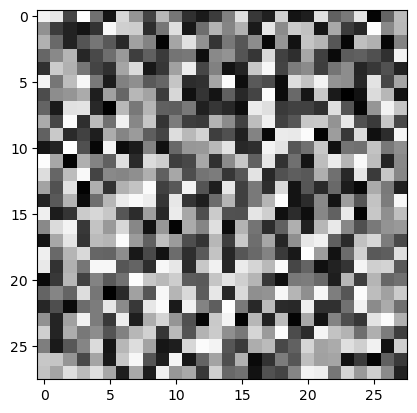

In [70]:
plt.imshow(transform_to_pil(x_t[0]), cmap='gray')

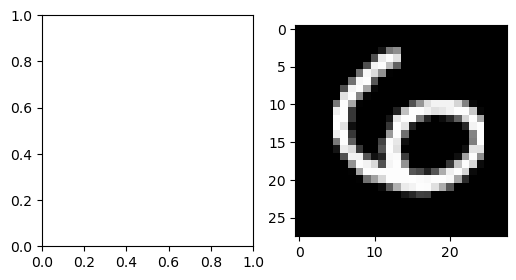

In [ ]:
# img, index = next(iter(train_dataloader))
# revert_image = transform_to_pil(img[0])
# fig, axes = plt.subplots(1, 2, figsize=(6, 3))
# # axes[0].imshow(img[0], cmap='gray')
# axes[1].imshow(revert_image, cmap='gray')

# img, index = dataset[20]
# tensor = torchvision.transforms.ToTensor()(img)

# fig, axes = plt.subplots(1, 5, figsize=(15, 3))
# axes[0].imshow(img, cmap='gray')
# index = 1
# for t in [1, 4, 8, 40]:
#     noise = torch.randn_like(tensor)
#     new_image = sqrt_bar_alpha_t_schedule[t] * tensor + sqrt_minus_bar_alpha_t_schedule[t] * noise
#     axes[index].imshow(torchvision.transforms.ToPILImage()(new_image), cmap='gray')
#     index += 1